In [ ]:
!git clone https://github.com/mylonasc/voxceleb2-npy-files.git

# Github does now allow pushing commits larger than 2GB. 
# np_files is commited in two folders that are here collated into one for use:
!cp voxceleb2-npy-files/voxceleb2/np_files_a/*  voxceleb2-npy-files/voxceleb2/np_files_b/ && mv voxceleb2-npy-files/voxceleb2/np_files_b/ voxceleb2-npy-files/voxceleb2/np_files/
!mv voxceleb2-npy-files/* .

# optional: needed for scraping more voxceleb data:
!pip install pytube

Cloning into 'voxceleb2-npy-files'...
remote: Enumerating objects: 7170, done.
remote: Total 7170 (delta 0), reused 0 (delta 0), pack-reused 7170
Receiving objects: 100% (7170/7170), 2.70 GiB | 12.98 MiB/s, done.
Checking out files: 100% (7159/7159), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 56 kB 3.9 MB/s 


In [1]:
from voxceleb2_dataset import VoxCeleb2Dataset

dataset = VoxCeleb2Dataset(cache_folder = '.')

# A list of all the available speakers. They are indexed by integers.
speakers = list(dataset.speaker_set)

# A list of indices for the files corresponding to one speaker:
data_inds = dataset.get_speaker_avail_inds(speakers[0])

# Loading the npy files that contain the voice segments for that speaker:
all_wavs_for_speaker = [dataset.read_index(i) for i in data_inds]

read 7156 files from cache covering 1424 speakers.


In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [57]:
# # %%timeit
# sp = np.random.choice(len(speakers))
# data_inds = dataset.get_speaker_avail_inds(speakers[int(sp)])
# all_wavs_for_speaker = [dataset.read_index(i) for i in data_inds]

In [91]:
## Loading a Huggingface model in order to use its embeddings:
import numpy as np
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
import torch

# load model and tokenizer
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [92]:
speaker_list = list(dataset.speaker_set)
n_test_speakers = 10
train_speakers, test_speakers = speaker_list[0:-5], speaker_list[-5:]
print('training on %i speakers and testing on %i speakers'%(len(train_speakers), len(test_speakers)))


training on 1419 speakers and testing on 5 speakers


In [107]:
all_speakers = list(dataset.speaker_set)

# A list of indices for the files corresponding to one speaker:
# data_inds = dataset.get_speaker_avail_inds(speakers[0])

# Loading the npy files that contain the voice segments for that speaker:
# all_wavs_for_speaker = [dataset.read_index(i) for i in data_inds]

def _sample_random_speaker_uterances(n_speakers = 2,
                                     n_uterances = 2,
                                     max_utterance_length = 3,
                                     sampling_rate = 16000,
                                     speakers_list = None):
    
    sp_inds = np.random.choice(len(speakers_list), n_speakers, replace = False)
    all_dat = [];
    def _pad_or_get_random_seg(arr : np.ndarray, pad_length_samples : int = int(sampling_rate * max_utterance_length)):
        """
        pads the input array if it is smaller than pad_length or
        gets a random segment of the utternace of `max_utterance_length`
        if the array is larger than pad_length.

        Args:
            arr: a numpy array
            pad_length: pad/trim length

        Returns:
            padded_trimmed_array, mask_is_padded
        """
        if arr.shape[0] > pad_length_samples:
            start_sample = np.random.choice(arr.shape[0] - pad_length_samples - 1)
            arr_other = arr[start_sample:start_sample+pad_length_samples]
            return np.zeros_like(arr_other), arr_other
        
        if arr.shape[0]<pad_length_samples:
            # arr_padded = np.pad(arr, pad_length_samples, 'constant')
            return np.hstack([np.zeros_like(arr), np.ones(pad_length_samples-arr.shape[0],)]), np.hstack([arr, np.zeros(pad_length_samples - arr.shape[0],)])

    for s in sp_inds:
        avail_inds_for_speaker = dataset.get_speaker_avail_inds(all_speakers[s])
        if len(avail_inds_for_speaker) >= n_uterances:
            _repl = False
        else:
            _repl = True
        data_inds = np.random.choice(avail_inds_for_speaker, n_uterances, replace = _repl) 

        speaker_utterances = [(_pad_or_get_random_seg(d[0]), d[1]) for d in map(dataset.read_index, data_inds)]
        all_dat.extend(speaker_utterances)

    return all_dat


In [108]:
all_dat=_sample_random_speaker_uterances(n_speakers = 2, n_uterances=2, speakers_list = train_speakers)
from IPython.display import Audio, display

for i in range(len(all_dat)):
    display(Audio(all_dat[i][0][1], rate = 16000, autoplay=0))

In [109]:
from torch.nn.modules.normalization import LayerNorm
# create a model that uses the feature extractor and another layer for speaker
#  embedding.
class SpeakerEmbFromFeatureExtractor(torch.nn.Module):
    def __init__(self,
                 base_model_feature_extractor, 
                 emb_size  = 256,
                 base_model_out_size = 512,  
                 device = 'cuda',
                 *args, **kwargs):
        super(SpeakerEmbFromFeatureExtractor,self).__init__(*args,**kwargs)
        # freeze the layers of the base model:
        for param in base_model_feature_extractor.parameters():
            param.requires_grad = False
        # base_model_feature_extractor
        # model = torch.nn.Sequential(
        #     base_model_feature_extractor,
        #     torch.nn.Conv1d(base_model_out_size, emb_size,1),
        #     torch.nn.AvgPool1d(kernel_size = 100, stride = 10),
        # )
        self.feat_extr = base_model_feature_extractor
        model = torch.nn.Sequential(
            self.feat_extr,
            torch.nn.Conv1d(base_model_out_size, emb_size,1)
        )
        
        self.last_layer_norm= torch.nn.LayerNorm(emb_size)
        
        self.model = model

    def forward(self, data):
        feats = self.model(data)
        res = self.last_layer_norm(feats.permute(0,2,1)).permute(0,2,1)
        return res.mean(dim = (-1)).unsqueeze(-1)

In [110]:
sp_model = SpeakerEmbFromFeatureExtractor(base_model_feature_extractor = model.base_model.feature_extractor)
sp_model.cuda()

SpeakerEmbFromFeatureExtractor(
  (feat_extr): Wav2Vec2FeatureEncoder(
    (conv_layers): ModuleList(
      (0): Wav2Vec2GroupNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (activation): GELUActivation()
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
      )
      (1): Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (2): Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (3): Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (4): Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (5): Wav2

In [111]:
csim = torch.nn.CosineSimilarity()
def contrastive_loss(wavs, labs):
    embs = sp_model(wavs)
    # We want the embeddings for the chunks that belong to the same segment to be close
    # and the ones that belong to different chunks to be far away:
    # csim(wavs)
    loss = 0
    for i,e1 in enumerate(embs):
        for j,e2 in enumerate(embs):
            if i >=j:
                continue
            if i != j:
                if labs[i] == labs[j]:
                    loss -= csim(e1.transpose(1,0),e2.transpose(1,0))
                if labs[i] != labs[j]:
                    loss += csim(e1.transpose(1,0),e2.transpose(1,0))
    return loss

In [112]:
def _get_random_sample(n_speakers = 4, n_utt = 3, speakers_list = train_speakers):
    all_dat=_sample_random_speaker_uterances(n_speakers = n_speakers, n_uterances=n_utt, speakers_list = train_speakers)
    # contrastive_loss

    dat_to_pass = []
    labs_to_pass =[]
    for dat, lab in map(lambda x : (x[0][1] , x[1]) , all_dat):
        dat_to_pass.append(dat)
        labs_to_pass.append(lab)
    return torch.tensor(np.stack(dat_to_pass,0).astype('float32')), labs_to_pass

In [113]:
# a static validation set consisting of random sets of the test speakers:
val_wav_tot = []
val_labs_tot = []
for k in range(10):
    val_wav, val_labs = _get_random_sample(n_speakers = 4, n_utt = 3, speakers_list = test_speakers)
    val_wav_tot.append(val_wav)
    val_labs_tot.append(val_labs)

In [114]:
def _eval_val_loss():
    loss_tot= 0
    for v_, l_ in zip(val_wav_tot, val_labs_tot):
        loss_partial = contrastive_loss(v_.cuda(), l_)
        loss_tot += loss_partial.detach().cpu().numpy()
    return loss_tot

_eval_val_loss()

array([419.4682], dtype=float32)

In [115]:
wav,lab = _get_random_sample(n_speakers = 2, n_utt = 2)
embs = sp_model(wav.cuda())

In [116]:
opt = torch.optim.Adam(sp_model.parameters(), lr = 0.0001)
losses = [];

In [117]:
from google.colab import drive
drive.mount('/content/drive/')
exp_root = '/content/drive/MyDrive/Experiments-speaker-diarization/exper_5'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [118]:
!mkdir /content/drive/MyDrive/Experiments-speaker-diarization/exper_5

mkdir: cannot create directory ‘/content/drive/MyDrive/Experiments-speaker-diarization/exper_5’: File exists


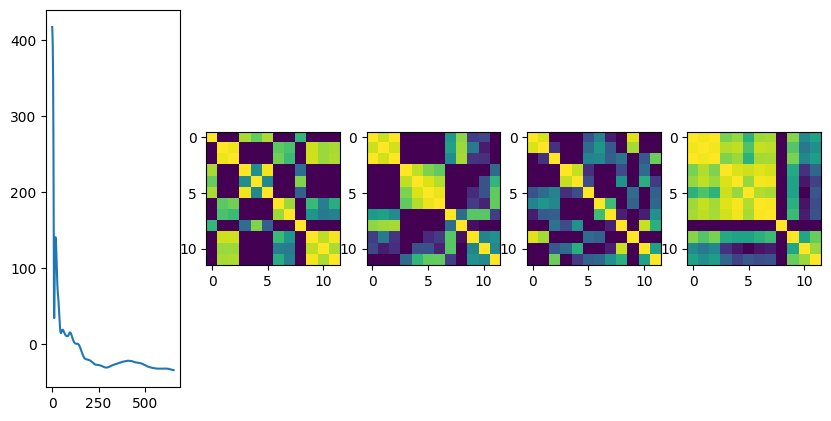

 66%|██████▌   | 6589/10000 [16:11<05:21, 10.60it/s]

In [ ]:
import matplotlib.pyplot as pplot
from tqdm import tqdm
from IPython.display import clear_output
import os

for epoch in tqdm(range(10000)):
    try:
        dat, labs = _get_random_sample()
    except:
        continue
    loss = contrastive_loss(dat.to('cuda'), labs)
    mean_loss = torch.mean(loss.to('cuda'))
    mean_loss.backward()
    opt.step()

    if (epoch + 1) % 10 == 0:

        with torch.no_grad():
            losses.append(_eval_val_loss())

        clear_output()
        pplot.figure(figsize = (10,5), dpi = 100)
        pplot.subplot(1,5,1)
        pplot.plot(losses)
        def _eval_affinity_matrix(index_val_set):
            with torch.no_grad():
                emb = sp_model(val_wav_tot[index_val_set].cuda())
                ee = emb.detach().cpu().numpy().transpose(0,2,1).reshape(-1,256)
            A = ee @ ee.T
            D = np.diag(1/np.sqrt(np.diag(A)))
            An = D @ A @ D
            return An
        
        for i in range(4):
            An = _eval_affinity_matrix(i)
            pplot.subplot(1,5,2+i)
            pplot.imshow(An * 1.*(An>0))

    if (epoch+1) % 100 == 0:
        pplot.savefig(os.path.join(exp_root,'step_%05i.png'%(epoch + len(losses))))
        model_save_path = os.path.join(exp_root, 'model_step_%04i.pt'%(epoch + len(losses)))
        torch.save(sp_model.state_dict(),model_save_path)
    if (epoch+1) %200 == 0:
        # reduce the learning rate every 200 steps:
        opt.param_groups[0]['lr'] = opt.param_groups[0]['lr']*0.98
    pplot.show()


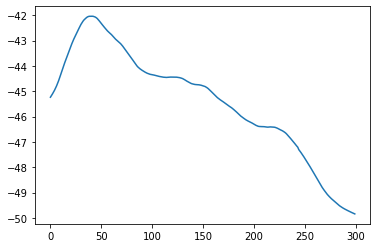

In [90]:
pplot.plot(losses[-300:])

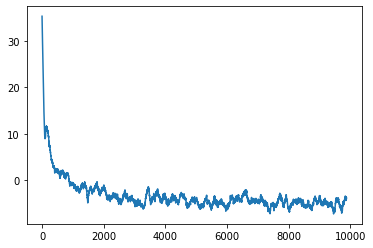

In [17]:
pplot.plot(np.convolve(np.stack(losses,0), np.ones(100)/100. ,'valid'))

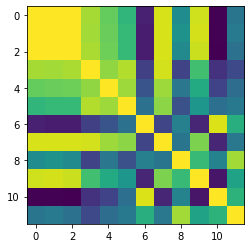

In [36]:
dat, labs = _get_random_sample()
emb = sp_model(dat.cuda())
ee = emb.cpu().detach().numpy().transpose(0,2,1).reshape(-1,256)
A = ee @ ee.T
D = np.diag(1/np.sqrt(np.diag(A)))
An = D @ A @ D
pplot.imshow(An)


In [37]:

from IPython.display import display, Audio
for d in dat.cpu():
    display(Audio(d, rate = 16000))

In [ ]:
mean_loss.backward()

In [33]:
loss

tensor([ 1.5436, -0.6875, -0.7370, -0.8200, -0.9520, -0.8695, -1.2019, -1.4848,
        -1.4867, -0.7482,  0.9301,  1.6200,  2.2531,  2.4794,  1.7515,  0.3881,
        -0.0468, -0.0125, -0.6471, -1.7457, -1.6502, -1.1736, -0.4311,  1.5334,
         2.7927,  2.5459,  1.7345,  0.0695, -1.0670, -0.8878, -0.2077,  0.2096,
         0.9166,  0.5566,  0.8108,  0.2919,  0.1226, -0.1545, -0.4954, -1.0238,
        -1.1279, -1.3324, -1.3720, -1.1528, -1.0253, -1.0527, -1.3246, -0.2488,
         0.8617,  1.9646,  2.0146,  1.2291,  0.4162, -0.8821, -1.8617, -2.1161,
        -1.8581, -1.2004, -1.0998, -1.4310, -1.5638, -1.3084, -0.3816,  1.4713,
         1.3001,  1.0031,  2.2940,  2.0038,  1.0214,  0.8266],
       grad_fn=<AddBackward0>)